# 04.01 DC GAN

----

Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

----


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

import os

import kagglehub
from pathlib import Path

## 1. Parameters

In [2]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 2. Prepare Data

Found 40000 files belonging to 1 classes.


2025-05-06 19:57:13.304079: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-06 19:57:13.304113: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-06 19:57:13.304122: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-06 19:57:13.304155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-06 19:57:13.304171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


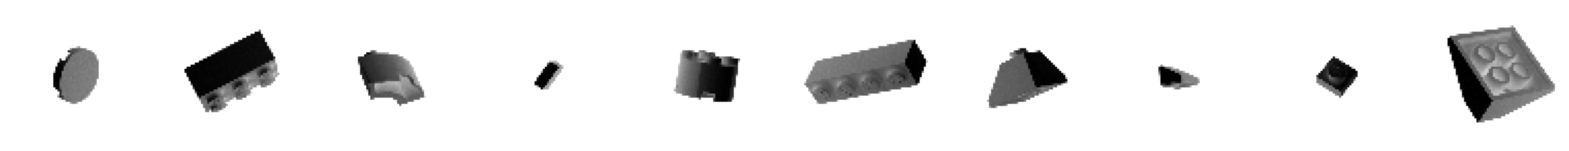

In [3]:
# Download latest version
data_path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")
data_img_folder = os.path.join(data_path, "dataset")

train_data = utils.image_dataset_from_directory(
    data_img_folder,
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

def preprocess(img):
    """
    Image normzliation
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


train = train_data.map(lambda x: preprocess(x))

train_sample = sample_batch(train)

# Show some items of clothing from the training set
plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(train_sample[i], cmap="gray_r")
    plt.axis("off")
plt.show()



## 3 DCGAN Model

In [4]:
# Discriminator
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [5]:
# Generator
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [6]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Latent space Sampling
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Training Discriminator
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metric
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [7]:
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

if LOAD_MODEL:
    dcgan.load_weights("./temp/checkpoint/checkpoint.ckpt")


dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

## 4. Training

Epoch 1/100


2025-05-06 19:57:15.089349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-06 19:57:15.197988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


313/313 [==============================] - ETA: 0s - d_loss: 0.7279 - d_real_acc: 0.6159 - d_fake_acc: 0.6087 - d_acc: 0.6123 - g_loss: 1.4462 - g_acc: 0.3914
Saved to ./temp/output/generated_img_000.png


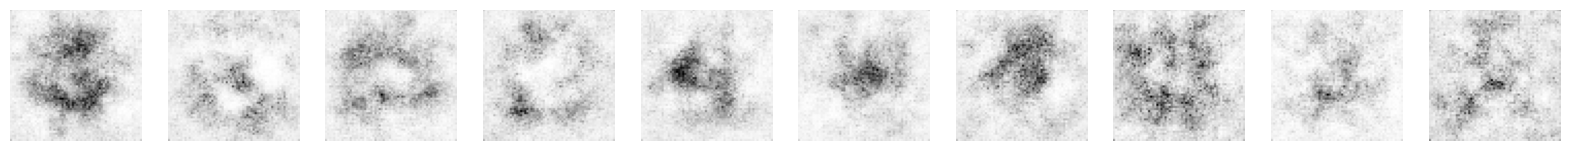

313/313 [==============================] - 39s 105ms/step - d_loss: 0.7279 - d_real_acc: 0.6159 - d_fake_acc: 0.6087 - d_acc: 0.6123 - g_loss: 1.4462 - g_acc: 0.3914
Epoch 2/100
313/313 [==============================] - 31s 99ms/step - d_loss: 0.5626 - d_real_acc: 0.6649 - d_fake_acc: 0.7040 - d_acc: 0.6844 - g_loss: 1.1196 - g_acc: 0.2960
Epoch 3/100
313/313 [==============================] - 32s 100ms/step - d_loss: 0.5435 - d_real_acc: 0.6769 - d_fake_acc: 0.7179 - d_acc: 0.6974 - g_loss: 1.1407 - g_acc: 0.2822
Epoch 4/100
313/313 [==============================] - 31s 100ms/step - d_loss: 0.5304 - d_real_acc: 0.6823 - d_fake_acc: 0.7260 - d_acc: 0.7042 - g_loss: 1.1691 - g_acc: 0.2740
Epoch 5/100
313/313 [==============================] - 31s 100ms/step - d_loss: 0.5093 - d_real_acc: 0.6978 - d_fake_acc: 0.7422 - d_acc: 0.7200 - g_loss: 1.2320 - g_acc: 0.2578
Epoch 6/100
313/313 [==============================] - 31s 98ms/step - d_loss: 0.4878 - d_real_acc: 0.7067 - d_fake_acc: 0.

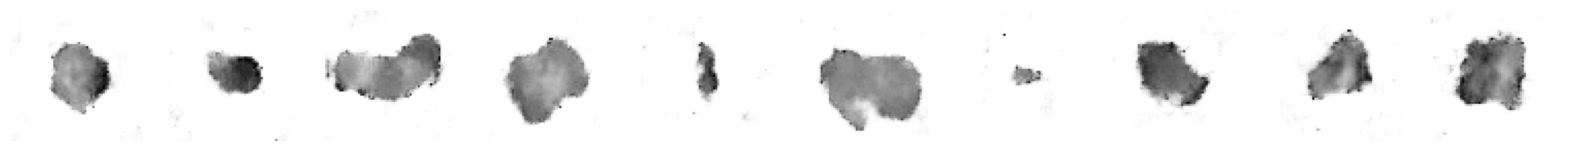

313/313 [==============================] - 31s 98ms/step - d_loss: 0.4089 - d_real_acc: 0.7480 - d_fake_acc: 0.8211 - d_acc: 0.7846 - g_loss: 1.5072 - g_acc: 0.1789
Epoch 12/100
313/313 [==============================] - 31s 98ms/step - d_loss: 0.3870 - d_real_acc: 0.7555 - d_fake_acc: 0.8337 - d_acc: 0.7946 - g_loss: 1.5777 - g_acc: 0.1663
Epoch 13/100
313/313 [==============================] - 31s 99ms/step - d_loss: 0.3712 - d_real_acc: 0.7636 - d_fake_acc: 0.8347 - d_acc: 0.7992 - g_loss: 1.6026 - g_acc: 0.1653
Epoch 14/100
313/313 [==============================] - 31s 99ms/step - d_loss: 0.3478 - d_real_acc: 0.7739 - d_fake_acc: 0.8464 - d_acc: 0.8102 - g_loss: 1.6822 - g_acc: 0.1535
Epoch 15/100
313/313 [==============================] - 31s 99ms/step - d_loss: 0.3307 - d_real_acc: 0.7821 - d_fake_acc: 0.8624 - d_acc: 0.8222 - g_loss: 1.7366 - g_acc: 0.1376
Epoch 16/100
313/313 [==============================] - 31s 99ms/step - d_loss: 0.3127 - d_real_acc: 0.7900 - d_fake_acc: 0

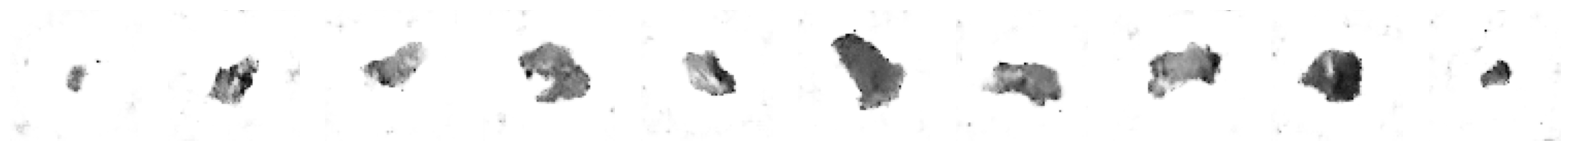

313/313 [==============================] - 33s 105ms/step - d_loss: 0.2191 - d_real_acc: 0.8263 - d_fake_acc: 0.9036 - d_acc: 0.8650 - g_loss: 2.1798 - g_acc: 0.0964
Epoch 22/100
313/313 [==============================] - 33s 105ms/step - d_loss: 0.2007 - d_real_acc: 0.8333 - d_fake_acc: 0.9009 - d_acc: 0.8671 - g_loss: 2.3387 - g_acc: 0.0991
Epoch 23/100
313/313 [==============================] - 33s 105ms/step - d_loss: 0.1917 - d_real_acc: 0.8351 - d_fake_acc: 0.9024 - d_acc: 0.8687 - g_loss: 2.3914 - g_acc: 0.0976
Epoch 24/100
313/313 [==============================] - 33s 105ms/step - d_loss: 0.1567 - d_real_acc: 0.8462 - d_fake_acc: 0.9128 - d_acc: 0.8795 - g_loss: 2.4959 - g_acc: 0.0872
Epoch 25/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.1542 - d_real_acc: 0.8481 - d_fake_acc: 0.9191 - d_acc: 0.8836 - g_loss: 2.5280 - g_acc: 0.0809
Epoch 26/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.1126 - d_real_acc: 0.8596 - d_fake_

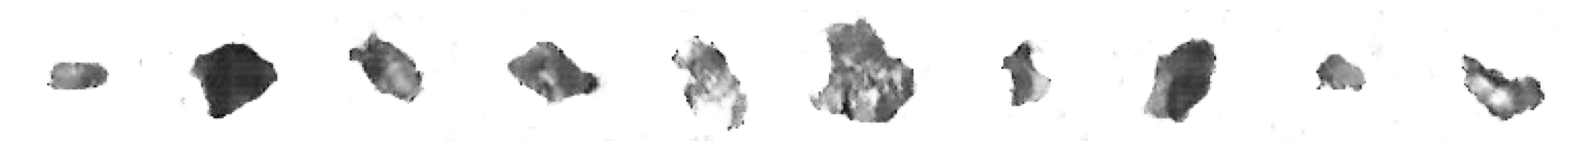

313/313 [==============================] - 33s 105ms/step - d_loss: 0.0743 - d_real_acc: 0.8673 - d_fake_acc: 0.9203 - d_acc: 0.8938 - g_loss: 3.1229 - g_acc: 0.0797
Epoch 32/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.0667 - d_real_acc: 0.8706 - d_fake_acc: 0.9220 - d_acc: 0.8963 - g_loss: 3.1786 - g_acc: 0.0780
Epoch 33/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.1037 - d_real_acc: 0.8625 - d_fake_acc: 0.9161 - d_acc: 0.8893 - g_loss: 3.2152 - g_acc: 0.0839
Epoch 34/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.0139 - d_real_acc: 0.8832 - d_fake_acc: 0.9392 - d_acc: 0.9112 - g_loss: 3.2413 - g_acc: 0.0608
Epoch 35/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.0046 - d_real_acc: 0.8849 - d_fake_acc: 0.9366 - d_acc: 0.9107 - g_loss: 3.4366 - g_acc: 0.0633
Epoch 36/100
313/313 [==============================] - 33s 104ms/step - d_loss: 0.0160 - d_real_acc: 0.8834 - d_fake_

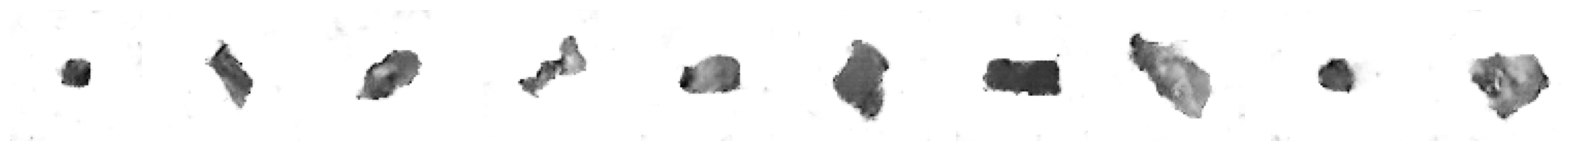

313/313 [==============================] - 33s 105ms/step - d_loss: -0.0431 - d_real_acc: 0.8947 - d_fake_acc: 0.9423 - d_acc: 0.9185 - g_loss: 3.9560 - g_acc: 0.0577
Epoch 42/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.0403 - d_real_acc: 0.8949 - d_fake_acc: 0.9413 - d_acc: 0.9181 - g_loss: 3.8918 - g_acc: 0.0587
Epoch 43/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.0597 - d_real_acc: 0.8977 - d_fake_acc: 0.9425 - d_acc: 0.9201 - g_loss: 4.1125 - g_acc: 0.0575
Epoch 44/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.0497 - d_real_acc: 0.8958 - d_fake_acc: 0.9386 - d_acc: 0.9172 - g_loss: 4.1645 - g_acc: 0.0614
Epoch 45/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.0168 - d_real_acc: 0.8895 - d_fake_acc: 0.9331 - d_acc: 0.9113 - g_loss: 4.0925 - g_acc: 0.0668
Epoch 46/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.0860 - d_real_acc: 0.9015 - d

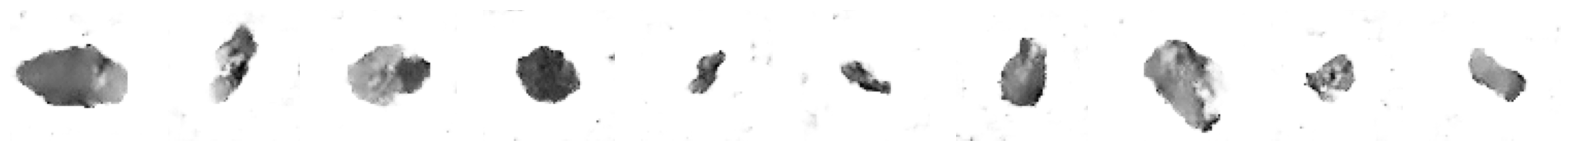

313/313 [==============================] - 33s 105ms/step - d_loss: -0.1189 - d_real_acc: 0.9079 - d_fake_acc: 0.9487 - d_acc: 0.9283 - g_loss: 4.6917 - g_acc: 0.0513
Epoch 52/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.0821 - d_real_acc: 0.9011 - d_fake_acc: 0.9444 - d_acc: 0.9227 - g_loss: 4.5678 - g_acc: 0.0556
Epoch 53/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.1091 - d_real_acc: 0.9072 - d_fake_acc: 0.9474 - d_acc: 0.9273 - g_loss: 4.6449 - g_acc: 0.0526
Epoch 54/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.0777 - d_real_acc: 0.9009 - d_fake_acc: 0.9459 - d_acc: 0.9234 - g_loss: 4.7049 - g_acc: 0.0541
Epoch 55/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1048 - d_real_acc: 0.9056 - d_fake_acc: 0.9472 - d_acc: 0.9264 - g_loss: 4.6581 - g_acc: 0.0528
Epoch 56/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.0955 - d_real_acc: 0.9017 - d

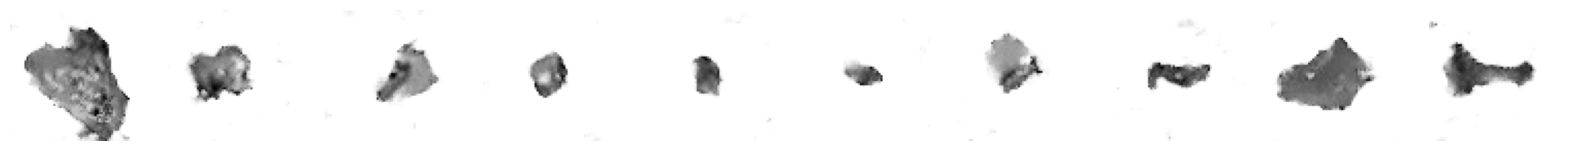

313/313 [==============================] - 33s 105ms/step - d_loss: -0.1025 - d_real_acc: 0.9013 - d_fake_acc: 0.9375 - d_acc: 0.9194 - g_loss: 5.2884 - g_acc: 0.0625
Epoch 62/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.1601 - d_real_acc: 0.9145 - d_fake_acc: 0.9528 - d_acc: 0.9336 - g_loss: 5.0869 - g_acc: 0.0472
Epoch 63/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1418 - d_real_acc: 0.9126 - d_fake_acc: 0.9499 - d_acc: 0.9312 - g_loss: 5.2535 - g_acc: 0.0501
Epoch 64/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1444 - d_real_acc: 0.9104 - d_fake_acc: 0.9466 - d_acc: 0.9285 - g_loss: 5.4848 - g_acc: 0.0534
Epoch 65/100
313/313 [==============================] - 34s 107ms/step - d_loss: -0.1561 - d_real_acc: 0.9133 - d_fake_acc: 0.9512 - d_acc: 0.9323 - g_loss: 5.3670 - g_acc: 0.0488
Epoch 66/100
313/313 [==============================] - 33s 106ms/step - d_loss: -0.1710 - d_real_acc: 0.9172 - d

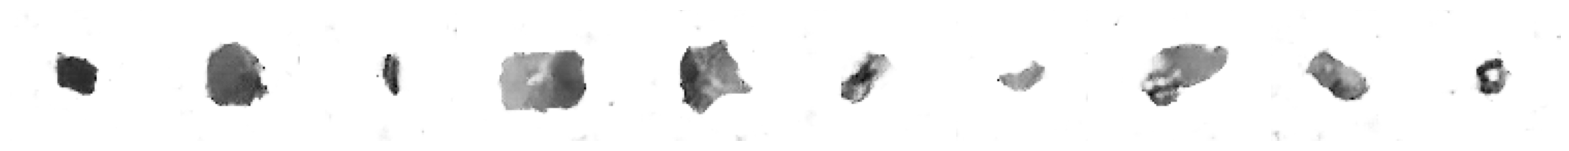

313/313 [==============================] - 33s 105ms/step - d_loss: -0.1680 - d_real_acc: 0.9150 - d_fake_acc: 0.9497 - d_acc: 0.9323 - g_loss: 5.7516 - g_acc: 0.0503
Epoch 72/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1895 - d_real_acc: 0.9174 - d_fake_acc: 0.9542 - d_acc: 0.9358 - g_loss: 5.7406 - g_acc: 0.0458
Epoch 73/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1994 - d_real_acc: 0.9211 - d_fake_acc: 0.9596 - d_acc: 0.9403 - g_loss: 5.7295 - g_acc: 0.0404
Epoch 74/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1671 - d_real_acc: 0.9152 - d_fake_acc: 0.9511 - d_acc: 0.9331 - g_loss: 5.8045 - g_acc: 0.0489
Epoch 75/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.2098 - d_real_acc: 0.9243 - d_fake_acc: 0.9605 - d_acc: 0.9424 - g_loss: 5.9264 - g_acc: 0.0395
Epoch 76/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.2337 - d_real_acc: 0.9281 - d

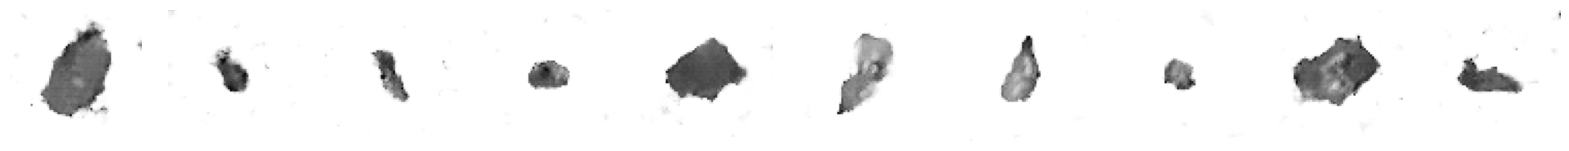

313/313 [==============================] - 33s 106ms/step - d_loss: -0.2626 - d_real_acc: 0.9312 - d_fake_acc: 0.9664 - d_acc: 0.9488 - g_loss: 6.1508 - g_acc: 0.0336
Epoch 82/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.2244 - d_real_acc: 0.9237 - d_fake_acc: 0.9570 - d_acc: 0.9403 - g_loss: 6.4226 - g_acc: 0.0430
Epoch 83/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.2181 - d_real_acc: 0.9240 - d_fake_acc: 0.9584 - d_acc: 0.9412 - g_loss: 6.2231 - g_acc: 0.0416
Epoch 84/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.2045 - d_real_acc: 0.9205 - d_fake_acc: 0.9531 - d_acc: 0.9368 - g_loss: 6.3589 - g_acc: 0.0469
Epoch 85/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.1309 - d_real_acc: 0.9076 - d_fake_acc: 0.9434 - d_acc: 0.9255 - g_loss: 5.9958 - g_acc: 0.0566
Epoch 86/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.2447 - d_real_acc: 0.9281 - d

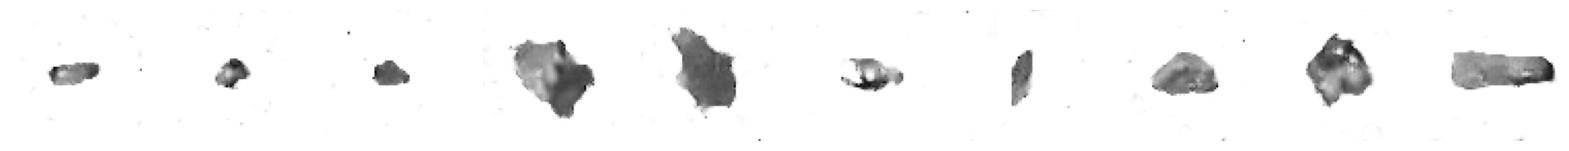

313/313 [==============================] - 33s 106ms/step - d_loss: -0.2500 - d_real_acc: 0.9276 - d_fake_acc: 0.9607 - d_acc: 0.9441 - g_loss: 6.6958 - g_acc: 0.0393
Epoch 92/100
313/313 [==============================] - 33s 106ms/step - d_loss: -0.2427 - d_real_acc: 0.9232 - d_fake_acc: 0.9558 - d_acc: 0.9395 - g_loss: 6.8738 - g_acc: 0.0442
Epoch 93/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.2272 - d_real_acc: 0.9223 - d_fake_acc: 0.9542 - d_acc: 0.9382 - g_loss: 6.8230 - g_acc: 0.0459
Epoch 94/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.2513 - d_real_acc: 0.9279 - d_fake_acc: 0.9613 - d_acc: 0.9446 - g_loss: 6.6522 - g_acc: 0.0388
Epoch 95/100
313/313 [==============================] - 33s 105ms/step - d_loss: -0.1759 - d_real_acc: 0.9177 - d_fake_acc: 0.9564 - d_acc: 0.9370 - g_loss: 6.8506 - g_acc: 0.0436
Epoch 96/100
313/313 [==============================] - 33s 104ms/step - d_loss: -0.2862 - d_real_acc: 0.9324 - d

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


In [ ]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./temp/checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./temp/logs")

Path("./temp/output").mkdir(exist_ok=True, parents=True)
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./temp/output/generated_img_%03d.png" % (epoch),
            )

dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

# Save Image
generator.save("./temp/models/generator")
discriminator.save("./temp/models/discriminator")

## 5. Generate new images

1/1 [==============================] - 0s 41ms/step


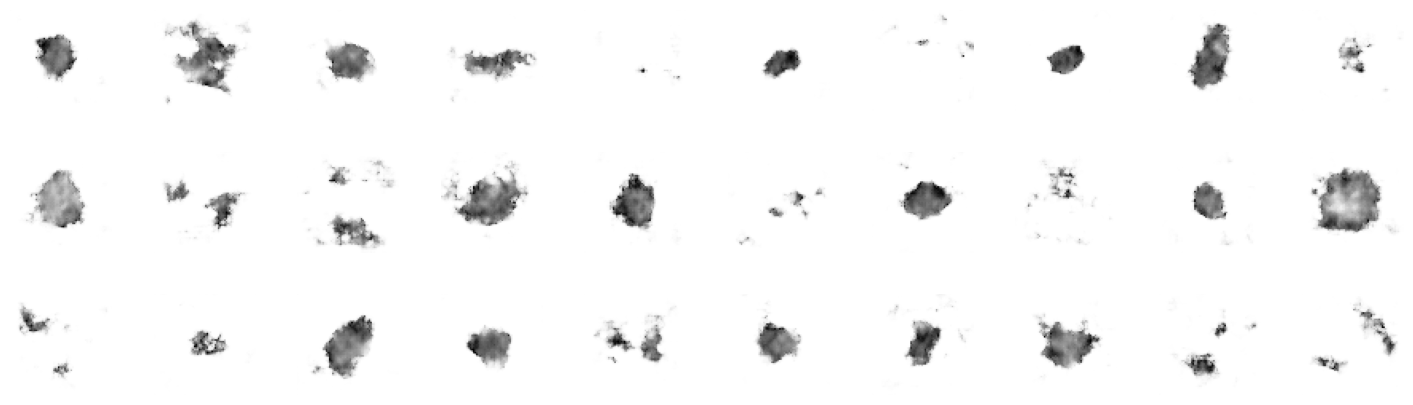

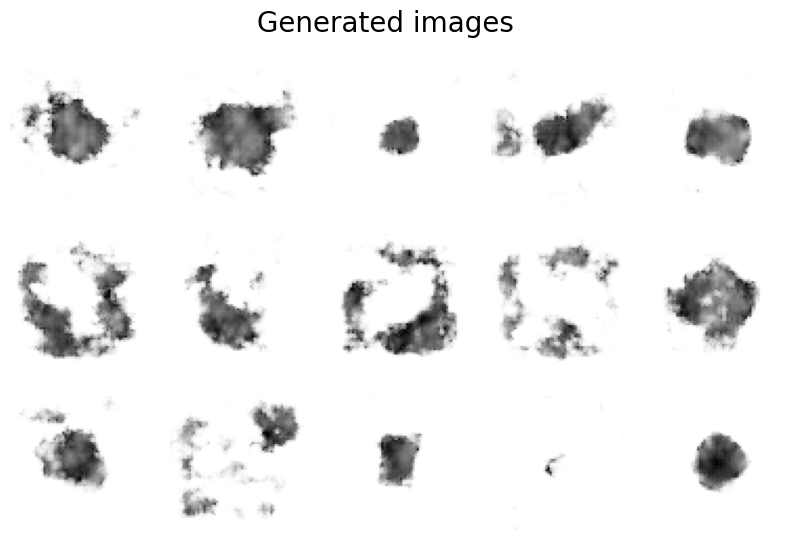

In [9]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

# Decode the sampled points
reconstructions = generator.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

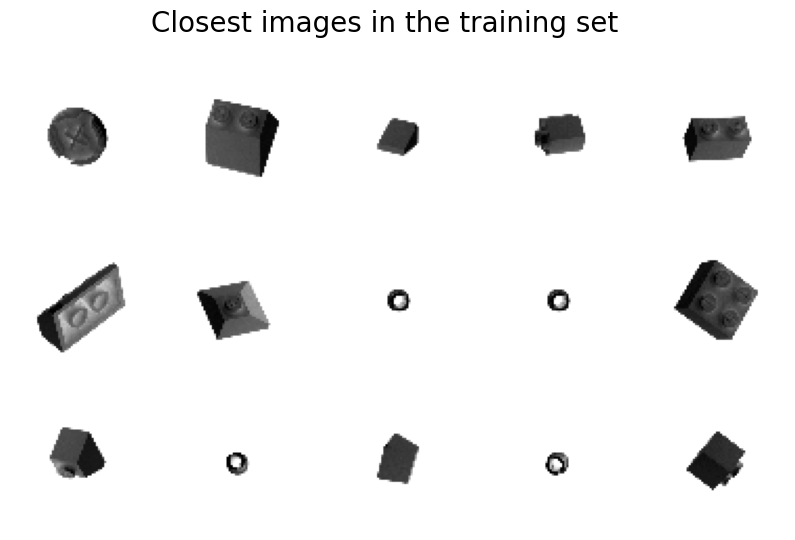

In [10]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()